# Regressão para diferentes bibliotecas

In [1]:
import pandas as pd
saida = pd.read_csv('/home/Jacks/saida.csv',encoding = 'UTF-8',sep=";")
print(saida)
x = saida['x'].values
y = saida['y'].values
errx = saida['errx'].values
erry = saida['erry'].values

         x      y   errx    erry
0    1.377  40.88  0.039  0.1501
1    1.463  41.31  0.036  0.1301
2    1.538  40.26  0.034  0.0701
3    1.577  40.41  0.034  0.1001
4    1.454  40.48  0.036  0.0701
..     ...    ...    ...     ...
102  1.660  41.74  0.033  0.1001
103  1.318  40.48  0.046  0.1101
104  1.568  41.06  0.033  0.1101
105  1.393  40.23  0.041  0.1001
106  1.573  41.19  0.033  0.1101

[107 rows x 4 columns]


## kapteyn, Scipy, numpy

In [2]:
#EXEMPLOS DE REGRESSÃO COM BIBLIOTECAS DIFERENTES
import numpy as np
from numpy.random import normal
from kapteyn import kmpfit
from scipy.odr import Data, Model, ODR, RealData, odr_stop

def model(p, x):
   # Model is staight line: y = a + b*x
   a, b = p
   return a + b*x

def residuals(p, data):
   # Residuals function for effective variance
   a, b = p
   x, y, ex, ey = data
   w = ey*ey + b*b*ex*ex
   wi = np.sqrt(np.where(w==0.0, 0.0, 1.0/(w)))
   d = wi*(y-model(p,x))
   return d

def residuals2(p, data):
   # Minimum distance formula with expression for x_model
   a, b = p
   x, y, ex, ey = data
   wx = 1/(ex*ex)
   wy = 1/(ey*ey)
   df = b
   xd = x + (wy*(y-model(p,x))*df)/(wx+wy*df*df)
   yd = model(p,xd)
   D = np.sqrt( wx*(x-xd)**2+wy*(y-yd)**2 )
   return D

#REGRESSÃO
print("\n========== Ajuste absoluto, sem incertezas =======")
a , b = np.polyfit(x,y,1)
beta0 = [b,a]
y_true = np.poly1d([a,b])
print("Parametro ajustado:    ",beta0)


print("\n========== Resultado SciPy's ODR ============")
linear = Model(model)
mydata = RealData(x, y, sx=errx, sy=erry)
myodr = ODR(mydata, linear, beta0=beta0, maxit=5000)
myoutput = myodr.run()
print("Fitted parameters:      ", myoutput.beta)
print("Covariance errors:      ", np.sqrt(myoutput.cov_beta.diagonal()))
print("Standard errors:        ", myoutput.sd_beta)
print("Minimum (reduced)chi^2: ", myoutput.res_var)
beta = myoutput.beta

# Prepare fit routine
fitobj = kmpfit.Fitter(residuals=residuals, data=(x, y, errx, erry),maxiter=5000)
try:
   fitobj.fit(params0=beta0)
except Exception as mes:
   print("Something wrong with fit: ", mes)
   raise SystemExit

print("\n\n======== Results kmpfit: w1 = ey*ey + b*b*ex*ex =========")
print("Params:                 ", fitobj.params)
print("Covariance errors:      ", fitobj.xerror)
print("Standard errors         ", fitobj.stderr)
print("Chi^2 min:              ", fitobj.chi2_min)
print("Reduced Chi^2:          ", fitobj.rchi2_min)
print("Message:                ", fitobj.message)

fitobj2 = kmpfit.Fitter(residuals=residuals2, data=(x, y, errx, erry),maxiter=5000)
try:
   fitobj2.fit(params0=beta0)
except Exception as mes:
   print("Something wrong with fit: ", mes)
   raise SystemExit

print("\n\n======== Results kmpfit: r = ex*ex/(ey*ey), xd = (x-a*r+y*b*r)/(1+r) =========")
print("Params:                 ", fitobj2.params)
print("Covariance errors:      ", fitobj2.xerror)
print("Standard errors         ", fitobj2.stderr)
print("Chi^2 min:              ", fitobj2.chi2_min)
print("Reduced Chi^2:          ", fitobj2.rchi2_min)
print("Message:                ", fitobj2.message)


t = "\nTHE WILLAMSON APPROACH"
print(t, "\n", "="*len(t))
# Step 1: Get a and b for a, b with standard weighted least squares calculation

def lingres(xa, ya, w):
   # Return a, b for the relation y = a + b*x
   # given data in xa, ya and weights in w
   sum   =  w.sum()
   sumX  = (w*xa).sum()
   sumY  = (w*ya).sum()
   sumX2 = (w*xa*xa).sum()
   sumY2 = (w*ya*ya).sum()
   sumXY = (w*xa*ya).sum()
   delta = sum * sumX2 - sumX * sumX 
   a = (sumX2*sumY - sumX*sumXY) / delta
   b = (sumXY*sum - sumX*sumY) / delta
   return a, b

w = np.where(erry==0.0, 0.0, 1.0/(erry*erry))
a,b = lingres(x, y, w)
a_y = a; b_y = b       # Williamson initial Parameters

ui = errx**2
vi = erry**2

n = 0 
cont = True
while cont:
   # Step 2: Use this slope to find weighting for each point
   wi = (vi+b*b*ui)**-1

   # Step 3: Calcu;ate weighted avarages
   w_sum = wi.sum()
   x_av = (wi*x).sum() / w_sum
   x_diff = x - x_av
   y_av = (wi*y).sum() / w_sum
   y_diff = y - y_av

   # Step 4: Calculate the 'improvement' vector zi
   zi = wi*(vi*x_diff + b*ui*y_diff)
   b_will = (wi*zi*y_diff).sum()/ (wi*zi*x_diff).sum()
   cont = abs(b-b_will) > 1e-12 and n < 100
   n += 1
   b = b_will

# Step 5: Repeat steps 2-4 until convergence

# Step 6: Calculate 'a' using the averages of a and y
a_will = y_av - b_will*x_av    # Improved parameters

# Step 7: The variances
wi = (vi+b_will*b_will*ui)**-1
w_sum = wi.sum()

z_av = (wi*zi).sum() / w_sum
zi2 = zi - z_av
Q =1.0/(wi*(x_diff*y_diff/b_will + 4*zi2*(zi-x_diff))).sum()
sigb2 = Q*Q * (wi*wi*(x_diff**2*vi+y_diff**2*ui)).sum()
siga2 = 1.0/w_sum + 2*(x_av+2*z_av)*z_av*Q + (x_av+2*z_av)**2*sigb2
siga = np.sqrt(siga2)
sigb = np.sqrt(sigb2)

print("Williamson Fitted A, B: ", a_will, b_will)
print("Parameter errors: ", siga, sigb)


========== Ajuste absoluto, sem incertezas =======
Parametro ajustado:     [35.19756008475314, 3.7147675918888083]

========== Resultado SciPy's ODR ============
Fitted parameters:       [33.70522073  4.65193812]
Covariance errors:       [0.21182613 0.1347031 ]
Standard errors:         [0.39581881 0.25170654]
Minimum (reduced)chi^2:  3.491674874032865


======== Results kmpfit: w1 = ey*ey + b*b*ex*ex =========
Params:                  [33.705207355748755, 4.651946766929969]
Covariance errors:       [0.21182619 0.13470313]
Standard errors          [0.39581892 0.2517066 ]
Chi^2 min:               366.62586168542435
Reduced Chi^2:           3.4916748731945177
Message:                 mpfit (potential) success: Convergence in chi-square value (1)


======== Results kmpfit: r = ex*ex/(ey*ey), xd = (x-a*r+y*b*r)/(1+r) =========
Params:                  [33.7052072429143, 4.651946838885838]
Covariance errors:       [0.2118262  0.13470314]
Standard errors          [0.39581894 0.25170661]
Chi^

## EMCEE

<function <lambda> at 0x7fb61617e430> [ 3.71476759 35.19756008  0.        ]
Maximum likelihood estimates:
m = 3.766
b = 35.110
f = 0.006


Text(0, 0.5, 'y')

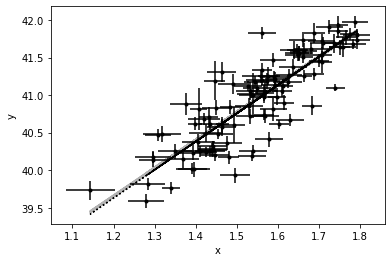

In [3]:
#Utilizando emcee para ajuste 1x1

import matplotlib.pyplot as plt
from scipy.optimize import minimize


def log_likelihood(theta, x, y,xerr ,yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = (yerr ** 2 + (m*xerr)**2) + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))

def log_prior(theta):
    m, b, log_f = theta
    if 1.0 < m < 6. and 33.0 < b < 39.0 and -6.0 < log_f < 5.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y,xerr , yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y,xerr, yerr)

b_true , m_true = beta0
f_true = 1

nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)])
soln = minimize(nll, initial, args=(x, y,errx, erry))
m_ml, b_ml, log_f_ml = soln.x
print(nll,initial)

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y,xerr=errx,yerr=erry, fmt=".k", capsize=0)
plt.plot(x, m_true * x + b_true, "k", alpha=0.3, lw=3, label="Original")
#plt.plot(x, np.dot(np.vander(x, 2), w), "--k", label="LS")
plt.plot(x, np.dot(np.vander(x, 2), [m_ml, b_ml]), ":k", label="ML")
#plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

  1%|          | 39/5000 [00:00<00:12, 381.82it/s]

100%|██████████| 5000/5000 [00:12<00:00, 406.52it/s]


[37.39908324 37.0162419  37.43498034]  Convergência de autocorrelação.
(9780, 3)  Nivelamento da amostra em linhas planas


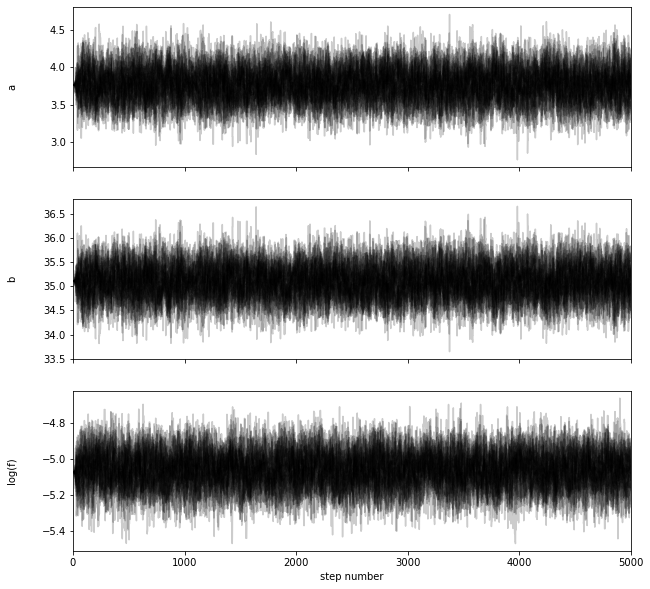

In [4]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(30,3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y,errx, erry))

print(sampler)

sampler.run_mcmc(pos, 5000, progress=True);

fig, axes = plt.subplots(3, figsize=(10, 10), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.2)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")


tau = sampler.get_autocorr_time()
print(tau, " Convergência de autocorrelação.")

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape,' Nivelamento da amostra em linhas planas')

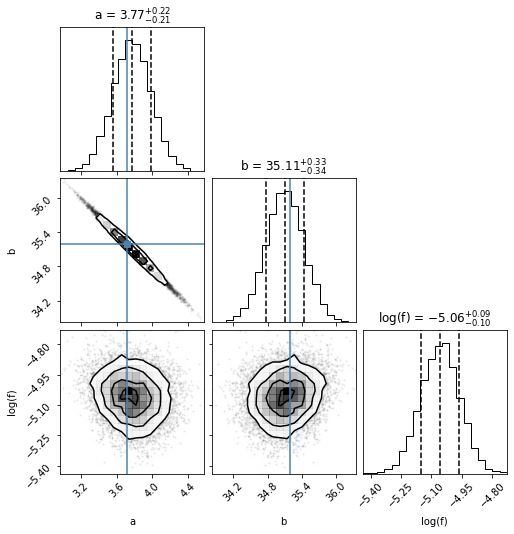

In [5]:
import corner

fig = corner.corner(
    flat_samples,show_titles=True, labels=labels, plot_datapoints=True, truths=[m_true, b_true, np.log(f_true)],quantiles=[0.16, 0.5, 0.84]
)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

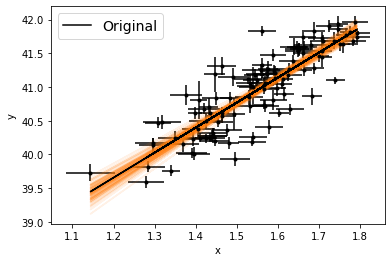

In [6]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x, np.dot(np.vander(x, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y,xerr=errx ,yerr=erry, fmt=".k", capsize=0)
plt.plot(x, m_true * x + b_true, "k", label="Original")
plt.legend(fontsize=14)
#plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))